In [1]:
############# MAINLY FOR COLAB
import Pkg
Pkg.activate("./")
Pkg.resolve()

  Activating project at `~/Documents/Research/MonitoringMetrology/BackAction.jl/notebooks`
  No Changes to `~/Documents/Research/MonitoringMetrology/BackAction.jl/notebooks/Project.toml`
  No Changes to `~/Documents/Research/MonitoringMetrology/BackAction.jl/notebooks/Manifest.toml`


In [2]:
using Plots, LinearAlgebra, BackAction

Precompiling packages...
  18527.6 ms  ✓ BackAction
  1 dependency successfully precompiled in 25 seconds. 285 already precompiled.


In [1]:
using LinearAlgebra, BackAction, Statistics, Distributed, DifferentialEquations, Test
addprocs(1)
@everywhere using BackAction


const NCHANNELS0::Int64 = 1
const NLEVELS::Int64 = 2
const OMEGA = 1.0
const GAMMA = 0.5

const tf = 2 * pi / OMEGA * 3
const tspan = (0.0, tf)
const ntimes = 100
const tlist = collect(LinRange(0.0, tf, ntimes))
const ntraj = 1000
const params_simul = BackAction.SimulParameters([0.0 + 0im, 1.0],
    tf, # Final time. Set very long so that all trajectories jump
    1, # seed
    ntraj,
    # GILLIPSIE STUFF 
    75_000, 3.0, 1e-3);
# Parameter Information
const delta = 0.1
# Unravelings
const T = reshape([1.0 + 0.0im], 1, 1)
const alphaa = [0.0 + 0.0im]
const nchannels = length(alphaa)

const sigma = [BackAction.sigma_x, BackAction.sigma_y, BackAction.sigma_z]

function get_lindbladsol(delta, tspan, u0)
    function rf_ode!(dr, r, p, t)
        dr[1] = -delta * r[2] - 0.5 * GAMMA * r[1]
        dr[2] = -OMEGA * r[3] + delta * r[1] - 0.5 * GAMMA * r[2]
        dr[3] = OMEGA * r[2] - GAMMA * (r[3] + 1)
    end
    prob = ODEProblem(rf_ode!, u0, tspan)
    return solve(prob)
end


## Stuff of the stationary solution
normalization_ss(delta) = 1 / (GAMMA^2 + 2 * OMEGA^2 + 4 * delta^2)
x_ss(delta) = normalization_ss(delta) * (-4 * delta * OMEGA)
y_ss(delta) = normalization_ss(delta) * (2 * GAMMA * OMEGA)
z_ss(delta) = normalization_ss(delta) * (-GAMMA^2 - 4 * delta^2)


u0 = [real(dot(params_simul.psi0, BackAction.sigma_x, params_simul.psi0)),
    real(dot(params_simul.psi0, BackAction.sigma_y, params_simul.psi0)),
    real(dot(params_simul.psi0, BackAction.sigma_z, params_simul.psi0))]
sol_lindblad = get_lindbladsol(delta, tspan, u0)

H = 0.5 * BackAction.sigma_x * OMEGA + 0.5 * BackAction.sigma_z * delta
Ls = reshape(sqrt(GAMMA) * BackAction.sigma_m, NLEVELS, NLEVELS, 1)
sys = System(H, Ls, NLEVELS, nchannels)

sim = get_sol_jumps(sys, params_simul, tspan, sigma, tlist )

########################## AVERAGE ##########################
teval = LinRange(tspan[1], tspan[end], ntimes)
# first index is the coordinate, second the time and third the sample number
psi = Vector{ComplexF64}(undef, 2)

tolerance_individualtrajectory_tracedistance = 0.01
@testset "Test MCWF" begin
    @testset "Correct Evolution, individual Trajectories" begin
        for i in 1:params_simul.ntraj
            @testset "Correct Evolution $i-th Trajectory " begin

                sol_sample_i = sim[i]
                affect!_sample_i = sol_sample_i.prob.kwargs[:callback].continuous_callbacks[1].affect!
                jumptimes_sample_i = affect!_sample_i.jump_times
                numberofjumps_sample_i = affect!_sample_i.jump_counter[] - 1 # The counter begins at 1

                innerproduct = 0.0
                expected_state = copy(params_simul.psi0)
                observed_state = Vector{ComplexF64}(undef, 2)

                expected_state .= exp(-1.0im * jumptimes_sample_i[1] * sys.Heff) * expected_state
                observed_state .= sol_sample_i(jumptimes_sample_i[1])

                innerproduct = dot(expected_state / norm(expected_state),
                    observed_state / norm(observed_state))
                @test sqrt(abs(1 - norm(innerproduct)^2)) < tolerance_individualtrajectory_tracedistance

                expected_state .= sys.Ls[:, :, 1] * expected_state
                expected_state .= expected_state / norm(expected_state)

                # check just before and just after the jump
                for k in 1:(numberofjumps_sample_i-1)
                    tau = jumptimes_sample_i[k+1] - jumptimes_sample_i[k]

                    expected_state .= exp(-1.0im * tau * sys.Heff) * expected_state
                    observed_state .= sol_sample_i(jumptimes_sample_i[k+1])
                    innerproduct = dot(expected_state / norm(expected_state), observed_state / norm(observed_state))

                    @test sqrt(abs(1 - norm(innerproduct)^2)) < tolerance_individualtrajectory_tracedistance

                    expected_state .= sys.Ls[:, :, 1] * expected_state
                    expected_state .= expected_state / norm(expected_state)
                    observed_state .= sol_sample_i(jumptimes_sample_i[k+1] + 1e-6)
                    innerproduct = dot(expected_state, observed_state / norm(observed_state))

                    @test sqrt(abs(1 - norm(innerproduct)^2)) < tolerance_individualtrajectory_tracedistance
                end
            end
        end
    end
    @testset "Correct Average Convergence" begin
        r_mean = average_expvals(sim)
        for k in 1:ntimes
            r_lindblad = sol_lindblad(tlist[k])
            difference_x = 0.5 * (r_lindblad[1] - r_mean[1, k])
            difference_y = 0.5 * (r_lindblad[2] - r_mean[2, k])
            difference_z = 0.5 * (r_lindblad[3] - r_mean[3, k])
            difference = difference_x * BackAction.sigma_x +
                         difference_y * BackAction.sigma_y +
                         difference_z * BackAction.sigma_y
            @test abs(0.5 * tr(sqrt(adjoint(difference) * difference))) < tolerance_individualtrajectory_tracedistance
        end
    end
end

Correct Evolution 2-th Trajectory : Error During Test at In[1]:69
  Got exception outside of a @test
  BoundsError: attempt to access 0-element Vector{Float64} at index [1]
  Stacktrace:
    [1] getindex(A::Vector{Float64}, i1::Int64)
      @ Base ./essentials.jl:13
    [2] macro expansion
      @ ./In[1]:80 [inlined]
    [3] macro expansion
      @ ~/julia/share/julia/stdlib/v1.10/Test/src/Test.jl:1577 [inlined]
    [4] macro expansion
      @ ./In[1]:71 [inlined]
    [5] macro expansion
      @ ~/julia/share/julia/stdlib/v1.10/Test/src/Test.jl:1577 [inlined]
    [6] macro expansion
      @ ./In[1]:68 [inlined]
    [7] macro expansion
      @ ~/julia/share/julia/stdlib/v1.10/Test/src/Test.jl:1577 [inlined]
    [8] top-level scope
      @ ./In[1]:67
    [9] eval
      @ ./boot.jl:385 [inlined]
   [10] include_string(mapexpr::typeof(REPL.softscope), mod::Module, code::String, filename::String)
      @ Base ./loading.jl:2146
   [11] softscope_include_string(m::Module, code::String, filen

LoadError: [91mSome tests did not pass: 7287 passed, 31 failed, 8 errored, 0 broken.[39m

In [3]:
#using Distributed
#addprocs(1)
#@everywhere using BackAction

In [3]:
using Statistics

In [3]:
using LaTeXStrings

In [98]:
using Test

In [7]:
#using Profile, ProfileView, BenchmarkTools

In [4]:
const NCHANNELS0::Int64 = 1
#const NCHANNELS::Int64 = 1
const NLEVELS::Int64 = 2
const OMEGA = 1.0 # NOTE: THESE ARE GAMMELMARK PARAMETERS
const GAMMA = 0.5;

In [5]:
const DELTA_RANGE::Vector{Float64} = collect(LinRange(0.0, 1.5, 100));

# Checking Solutions 
First thing first, I need to check that indeed the stuff that I'm seeing are solutions. For this I'll begin by setting up the precise 
Hamiltonian and jump operators of the master equation and extracting the stationary values of the Bloch coordinates.

$$
    H = \Delta \ketbra{e}{e} + \Omega \sigma_x/2 
$$

$$
    c = \sqrt{\gamma}\sigma_-
$$

This is the way Gammelmark and Molmer wrote it, but notice that one can add a constant  $-\frac{\Delta}{2}I$ to the Hamiltonian and obtain

$$
    H = \frac{\Delta}{2}\sigma_z + \frac{\Omega}{2}\sigma_x
$$

which is the way Wiseman writes it, I want it to use his form of the stationary solution

$$
\dot{x} = -\Delta y - \frac{\gamma}{2}x, \\
$$
$$
\dot{y} = -\Omega z + \Delta x - \frac{\gamma}{2}y, \\
$$
$$
\dot{z} = +\Omega y - \gamma(z + 1),
$$

$$
\begin{pmatrix}
x \\
y \\
z
\end{pmatrix}_{\text{ss}}
=
\begin{pmatrix}
-4\Delta\Omega \\
2\Omega\gamma \\
-\gamma^2 - 4\Delta^2
\end{pmatrix}
\left( \gamma^2 + 2\Omega^2 + 4\Delta^2 \right)^{-1}.
$$

In [57]:
## Stuff of the stationary solution
normalization_ss(delta) = 1/(GAMMA^2 + 2*OMEGA^2 + 4*delta^2) ## normalization factor
x_ss(delta) = normalization_ss(delta)*(-4*delta*OMEGA)
y_ss(delta) = normalization_ss(delta)*(2*GAMMA*OMEGA)
z_ss(delta) = normalization_ss(delta)*(-GAMMA^2-4*delta^2)

z_ss (generic function with 1 method)

Ok! Now I'm good to go with trying the solutions, first for good practice I'll do it for all times. 

# Setup 

In [5]:
delta = 0.1

0.1

In [92]:
tf = 2*pi/OMEGA * 10
tspan = (0,tf)
ntimes = 100
tlist = collect(LinRange(0.0, tf, ntimes))
ntraj = 1000
params_simul = BackAction.SimulParameters([0.0+0im, 1.0],
        tf, # Final time. Set very long so that all trajectories jump
        1, # seed
        ntraj,
        # GILLIPSIE STUFF 
        75_000, 3.0, 1e-3 );
# Parameter Information
delta = 0.1
ddelta = delta/100 + 1e-3
# Unravelings
T = reshape([1.0+0.0im], 1,1)
alphaa = [0.0+0.0im]
nchannels = length(alphaa)
# Jump operators and their derivatives
Ls = Array{ComplexF64}(undef, NLEVELS, NLEVELS, nchannels)
dLs = Array{ComplexF64}(undef, NLEVELS, NLEVELS, nchannels)

2×2×1 Array{ComplexF64, 3}:
[:, :, 1] =
 6.93338e-310+6.93338e-310im  6.93338e-310+6.93338e-310im
 6.93337e-310+6.93337e-310im  6.93331e-310+6.93337e-310im

# DifferentialEquations.jl Solution

In [81]:
using DifferentialEquations

In [82]:
# Solution Lindblad Equation via DifferentialEquations.jl
function get_lindbladsol(delta, tspan, u0)
    function rf_ode!(dr, r, p, t)
            dr[1] = -delta*r[2]-0.5*GAMMA*r[1]
            dr[2] = -OMEGA*r[3]+delta*r[1]-0.5*GAMMA*r[2]
            dr[3] = OMEGA*r[2]-GAMMA*(r[3]+1)
    end
    prob = ODEProblem(rf_ode!, u0, tspan)
    return solve(prob)
end

get_lindbladsol (generic function with 1 method)

In [83]:
sol_lindblad = get_lindbladsol(delta, tspan, [0.0, 0.0, 1.0]);

# Trajectory Solution

In [7]:
# Here I look for the solution from the trajectories, particularly using the same code as the one that calcualtes the Fisher Information
# First thing I need is to set functions for obtaining the jump operator and the hamiltonian
# Base parametric operators

# These are the functions definign the base unraveling
L0 = d -> sqrt(GAMMA) * BackAction.sigma_m
H0 = d -> 0.5*d*BackAction.sigma_z  + 0.5*OMEGA*BackAction.sigma_x 

# Generate functions with the correct unraveling
function obtain_parametric_unraveling_operators(T::Matrix{T1}, alpha::Vector{T1}) where {T1<:Complex}
    # First do the unitary mixing 
    Ls_mixed = BackAction.isometric_mixing([L0], T, NLEVELS, size(T)[1])
    H = BackAction.add_cfield_hamiltonian_correctionterm(H0, Ls_mixed, alpha, NLEVELS)
    Ls_mixed_cfield = BackAction.add_cfields(Ls_mixed, alpha, NLEVELS)
    He = BackAction.get_Heff(H, Ls_mixed_cfield, NLEVELS)
    return Ls_mixed_cfield, H, He
end

obtain_parametric_unraveling_operators (generic function with 1 method)

In [60]:
function get_trajectorysample(delta::T2, ddelta::T2, # Parameter information
        T::Matrix{T1}, alpha::Vector{T1}, nchannels::T3, # Specify the unraveling
        Ls::Array{T1}, dLs::Array{T1}, # Necessary matrices to store jump operators and it's derivatives
        params_simul::SimulParameters, tlist; # Simulation specifics: ntraj, tf and initial state
        kwargs... # Keywords for the solver
        ) where {T1<:Complex, T2<:Real, T3<:Int}
    Ls_par, H_par, He_par = obtain_parametric_unraveling_operators(T, alpha)
    evaluate_and_fill_Ls_dLs(Ls_par, delta, Ls, dLs, nchannels)
    sys = System(H_par(delta), Ls, NLEVELS, nchannels)
    He_forward = He_par(delta + 0.5*ddelta)
    He_backward = He_par(delta - 0.5*ddelta)
    #sim = get_sol_jumps_monitoring(ddelta, dLs, He_forward, He_backward, sys, params_simul, (0.0, params_simul.tf); 
    #                                #save_on=false, save_start=false, save_end=true)
    #                                kwargs...)
    sim = get_sol_jumps(sys, params_simul, (0.0, params_simul.tf),
        [BackAction.sigma_x, BackAction.sigma_y, BackAction.sigma_z], tlist)
end                    

get_trajectorysample (generic function with 2 methods)

In [61]:
trajectory_sample = get_trajectorysample(delta, delta/10 + 1e-1,
                                    T, alphaa, nchannels,
                                    Ls, dLs,
                                    params_simul, tlist);

In [79]:
r_mean = average_expvals(trajectory_sample)

3×100 Matrix{ComplexF64}:
 0.0+0.0im  0.0136363+0.0im  …  -0.179936+0.0im  -0.175268+0.0im
 0.0+0.0im  -0.371978+0.0im       0.43602+0.0im   0.431857+0.0im
 1.0+0.0im   0.308102+0.0im     -0.103182+0.0im  -0.120187+0.0im

In [103]:
tolerance_average = 0.01
@testset "Correct Average Convergence" begin 
    for k in 1:ntimes
        r_lindblad = sol_lindblad(tlist[k])
        difference_x = 0.5*(r_lindblad[1] - r_mean[1, k])
        difference_y = 0.5*(r_lindblad[2] - r_mean[2, k])
        difference_z = 0.5*(r_lindblad[3] - r_mean[3, k])
        difference = difference_x*BackAction.sigma_x + 
                     difference_y*BackAction.sigma_y +
                     difference_z*BackAction.sigma_y 
        @test abs(0.5*tr( adjoint(difference)*difference )) < tolerance_average
    end
end

Test Summary:               | Pass  Total  Time
Correct Average Convergence |  100    100  0.0s


Test.DefaultTestSet("Correct Average Convergence", Any[], 100, false, false, true, 1.753388368245444e9, 1.753388368261605e9, false, "In[103]")

In [94]:
tr

tr (generic function with 20 methods)

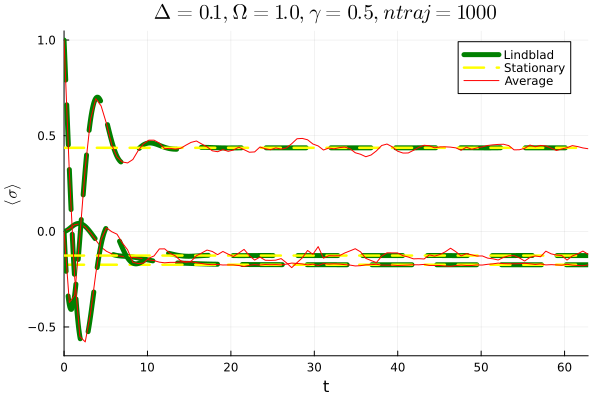

In [91]:
# x
plot(sol_lindblad, idxs = (0, 1), label="Lindblad", xlabel=L"t",
    ylabel=L"\langle\sigma\rangle", title=L"\Delta=%$delta, \Omega=%$OMEGA, \gamma=%$GAMMA, ntraj=%$(params_simul.ntraj)", 
    color="green", linewidth=5, line=:dash)
plot!([tspan[1], tspan[2]], ones(2)*x_ss(delta), line=:dash, label="Stationary", 
        color="yellow", linewidth=2.5)
plot!(tlist, real(r_mean[1, :]), label="Average", color="red")
# y
plot!(sol_lindblad, idxs = (0, 2), label=false, color="green", linewidth=5,
    line=:dash)
plot!([tspan[1], tspan[2]], ones(2)*y_ss(delta), line=:dash, label=false,
    color="yellow", linewidth=2.5)
plot!(tlist, real(r_mean[2, :]), label=false, color="red")
# z
plot!(sol_lindblad, idxs = (0, 3), label=false, color="green", line=:dash, 
      linewidth=5)
plot!([tspan[1], tspan[2]], ones(2)*z_ss(delta), line=:dash, label=false,
    color="yellow", linewidth=2.5)
plot!(tlist, real(r_mean[3, :]), label=false, color="red")

In [ ]:
# Set up the unravelings
function sample_c2(seed)
    theta = pi*rand()
    phi = 2*pi*rand()
    return [cos(theta*0.5); exp(1im*phi)*sin(theta*0.5)] 
end
function get_random_unraveling(seed)
    Random.seed!(seed)
    T = sample_c2(seed) 
    T = reshape(T/norm(T), 2,1)
    T_curvy = [real(T[1]) imag(T[1]); real(T[2]) imag(T[2]) ]
    F = svd(T_curvy) # Factorization object
    P = F.V * Diagonal(F.S) * F.Vt
    O = F.U * F.Vt
    T_curvy_dyne = O' * T_curvy
    T_dyne = O' * real.(T) + 1im * O' * imag.(T)
    Ta = T 
    Tb = T_dyne 
    Tc = T_dyne 
    Ts = Dict([("a", Ta), ("b", Tb), ("c", Tc)]) # Dictionary with the Ts
    alpha0 = [0.5 + 0im; 0.5 + 0im] 
    alphas = Dict([("a", alpha0), ("b", alpha0), ("c", O' * alpha0)]) # Dictionary with the alphas

    return Ts, alphas
end


In [6]:
# Base parametric operators

L0 = d -> sqrt(GAMMA) * BackAction.sigma_m
H0 = d -> d*[[0, 0] [0, 1.0+0im]]  + 0.5*OMEGA*BackAction.sigma_x 

# Unraveling parametrix operators
function obtain_parametric_unraveling_operators(T::Matrix{T1}, alpha::Vector{T1}) where {T1<:Complex}
    # First do the unitary mixing 
    Ls_mixed = BackAction.isometric_mixing([L0], T, NLEVELS, size(T)[1])
    H = BackAction.add_cfield_hamiltonian_correctionterm(H0, Ls_mixed, alpha, NLEVELS)
    Ls_mixed_cfield = BackAction.add_cfields(Ls_mixed, alpha, NLEVELS)
    He = BackAction.get_Heff(H, Ls_mixed_cfield, NLEVELS)
    return Ls_mixed_cfield, H, He
end


obtain_parametric_unraveling_operators (generic function with 1 method)

In [7]:
function calculate_fi(ensol)
    avg = 0.0
    aux = 0.0
    for sol in ensol 
        psi = sol.u[end]/norm(sol.u[end])
        phi = sol.prob.kwargs[:callback].affect!.cache_phi
        val = (2*real(dot(psi, phi)))^2
        avg = avg + val
        aux = aux + val^2
    end
    n = length(ensol)
    return avg/n, (aux - ((avg)^2)/n)/(n-1) 
end 

calculate_fi (generic function with 1 method)

In [13]:
function FisherInformationRoutine(theta::T2, dtheta::T2, tf::T2, T::Matrix{T1}, alpha::Vector{T1}, nchannels::T3,
        Ls::Array{T1}, dLs::Array{T1}, ntraj::T3) where {T1<:Complex, T2<:Real, T3<:Int}
    
    params_simul = BackAction.SimulParameters([0.0+0im, 1.0],
        tf, # Final time. Set very long so that all trajectories jump
        1, # seed
        ntraj, # Number of trajectories
        # GILLIPSIE STUFF 
        75_000, 3.0, 1e-3 )
    tspan = (0.0, tf)
    ## 1. define the T and alpha
    #nchannels = length(alpha)
    ## 2. Obtain the parametrizations of Ls, H and He
    Ls_par, H_par, He_par = obtain_parametric_unraveling_operators(T, alpha)
    ## 3. Evaluate the parametrizations
    evaluate_and_fill_Ls_dLs(Ls_par, theta, Ls, dLs, nchannels)
    ### 4. Initialzie the system
    sys = System(H_par(theta), Ls, NLEVELS, nchannels)
    ## Set up the derivatives of the jump operators
    #end
    ## Information for the derivatives
    #dtheta = delta/1000
    He_forward = He_par(theta + 0.5*dtheta )
    He_backward = He_par(theta - 0.5*dtheta)
    #
    sim = get_sol_jumps_monitoring(dtheta, dLs, He_forward, He_backward, sys, params_simul, tspan; 
                                    save_on=false, save_start=false, save_end=true)
    mean, var =  calculate_fi(sim)
    #return mean/tf, var/tf^2
    return mean/tf
end

FisherInformationRoutine (generic function with 1 method)

In [9]:
T = reshape([1.0+0im], 1,1) # MUST BE CONSISTENT WITH THE DIMENSIONS OF ALPHA
alpha = [0.0+0im]
nchannels = length(alpha)
Ls = Array{ComplexF64}(undef, NLEVELS, NLEVELS, nchannels)
dLs = Array{ComplexF64}(undef, NLEVELS, NLEVELS, nchannels)
theta = DELTA_RANGE[1]
dtheta = theta/1000
tf = 300.0
ntraj = 100


100

In [11]:
ndeltas = length(DELTA_RANGE)
nalphas = 1
alphamax = 2.0 + 0.0im
dalphas = alphamax/nalphas
alphas = [dalphas*m for m in 0:nalphas]
myfi = Array{Float64}(undef, ndeltas, nalphas);

In [14]:
for k in 1:nalphas
        println(alphas[k])
    @time begin
            for n in 1:ndeltas
                # you need to add the 0.0001 to avoid dividing by zero at delta=0
               myfi[n, k] = FisherInformationRoutine(DELTA_RANGE[n], DELTA_RANGE[n]/1000 + 0.0001,  
                            tf, T, [alphas[k]], nchannels, Ls, dLs, ntraj) 
            end 
        end
end

0.0 + 0.0im
 17.201198 seconds (14.41 M allocations: 663.898 MiB, 0.95% gc time, 0.35% compilation time)


In [13]:
myfi

100×1 Matrix{Float64}:
 NaN
   0.005098673053971783
   0.09408967502117747
   0.13440031998010812
   0.17577754871389936
   0.21349144206011483
   0.18906055094561702
   0.2547263342168694
   0.24770886793358154
   0.3596830974128386
   0.322923043832257
   0.30737468060255485
   0.4012941745557821
   ⋮
   0.13578897060272632
   0.1266140739476892
   0.12773341833194843
   0.12123678240719118
   0.11523381600067206
   0.10913945952561822
   0.11454050322656442
   0.12016705546224406
   0.11855622997202256
   0.1277228841483822
   0.13792454084828215
   0.14894717369947502

# Gammelmark-Molmer Bound


In [14]:
using LinearSolve
using ForwardDiff

In [15]:
function get_LMatrix(delta, omega, k)
    return [[0.0 0.5im*omega -0.5im*omega k];
            [0.5im*omega 1im*delta - 0.5*k 0.0 -0.5im*omega];
            [-0.5im*omega 0.0 -1im*delta-0.5*k 0.5im*omega];
            [0.0 -0.5im*omega 0.5im*omega -k]]
end

function get_LMatrixGeneralized(delta1, delta2, omega1, omega2, k1, k2)
    return [[0.0 0.5im*omega1 -0.5im*omega2 sqrt(k1*k2)];
            [0.5im*omega1 1im*delta1-0.5*k1 0.0 -0.5im*omega2];
            [-0.5im*omega2 0.0 -1im*delta2-0.5*k2 0.5im*omega1];
            [0.0 -0.5im*omega2 0.5im*omega1 1im*delta1-1im*delta2-k1/2-k2/2]]
end         



get_LMatrixGeneralized (generic function with 1 method)

In [16]:
function GMBound(delta)
    # First: Obtain the stationary state
    # Get the matrix form of the Liouville operator
    A = get_LMatrix(delta, OMEGA, GAMMA)
    A_aux = copy(A)
    A_aux[4, 1] = 1.0
    A_aux[4, 2] = 0.0
    A_aux[4, 3] = 0.0
    A_aux[4, 4] = 1.0
    # Solve the problem:
    b = [0.0+0.0im, 0.0, 0.0, 1.0]
    prob = LinearProblem(A_aux, b)
    sol = solve(prob)
    u0 = sol.u
    v0 = [1.0+0.0im, 0.0, 0.0, 1.0]
# Sanity check: this is the eigenvector with eigenvalue 0 and normalized
#println("norm(A*u0)=",  norm(A*u0))
#println("dot(v0,u0)>=",  dot(v0, u0))

    # Second: Obtian the pseudo inverse of -Lmatrix, and define the projector 
    # into the orthogonal complement of lambda0 eigenspace
    A_plus = pinv(-A)
    P0 = u0 * adjoint(v0)
    P = I - P0
    P_divided_A = P*A_plus*P

    # Sanity check: dot(u0, ui) = 0
    #ui = A_plus*P*Lgeneralized_delta(DELTA_GAMMELMARK[1])*u0
    Lgeneralized = d -> get_LMatrixGeneralized(d[1], d[2], OMEGA, OMEGA, GAMMA, GAMMA)
    Lgeneralized_leftfixed = d -> Lgeneralized([delta, d])
    Lgeneralized_rightfixed = d -> Lgeneralized([d, delta])
    #Lgeneralized_leftfixed(DELTA_GAMMELMARK[1])
    L_left = ForwardDiff.derivative(Lgeneralized_leftfixed, delta)
    L_right = ForwardDiff.derivative(Lgeneralized_rightfixed, delta)

# Fourth: sum all the matrices
    aux1 = zeros(ComplexF64, 4, 4)
    aux2 = L_left*P_divided_A*L_right + L_right*P_divided_A*L_left
    total_matrix =  aux1 + aux2

    return real(4*dot(v0, total_matrix*u0))
end 

GMBound (generic function with 1 method)

# Complete Plot

In [17]:
using LaTeXStrings

In [18]:
plot(DELTA_GAMMELMARK, myfi[:, 1], label=L"\alpha= %$(alphas[1])", linestyle=:dashdot, 
    xlabel=L"\Delta", ylabel=L"F(\Delta)/T")
for k in 2:nalphas
    plot!(DELTA_GAMMELMARK, myfi[:, k], label=L"\alpha = %$(alphas[k])", linestyle=:dash)
end
plot!(DELTA_GAMMELMARK, GMBound.(DELTA_GAMMELMARK), color="black", label="GM Bound")
savefig("FI.pdf")

LoadError: UndefVarError: `DELTA_GAMMELMARK` not defined